# Exoplanet Exploration through Data Mining
### Author: Josh Stanton

 Date: February 09, 2025


The NASA Exoplanet Archive file consists of 38,090 entries across 92 columns covering the planets'
mass relative to Earth and Jupiter, Insolation Flux, the Orbital Periods, among other properties.
In total, 38,090 rows by 92 columns results in just over 3.5 million points of data, which need to
be cleaned and tailored to answer the questions:

• Are there any patterns in exoplanet discovery over time?

• Do certain facilities have a propensity for discovering certain exoplanet types more than others?

• Is there a relationship between planet size and stellar gravity?

• Does the number of stars relative to an exoplanet have any effect on its orbital?

• Have specific discovery methods been more successful than others, or has a specific discovery method identified more planets than others?




In [2]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


exoplanets = pd.read_csv('NASA Exoplanet Archive.csv')


In [3]:
exoplanets.columns

Index(['Planet Name', 'Host Name', 'Default Parameter Set', 'Number of Stars',
       'Number of Planets', 'Discovery Method', 'Discovery Year',
       'Discovery Facility', 'Solution Type', 'Controversial Flag',
       'Planetary Parameter Reference', 'Orbital Period [days]',
       'Orbital Period Upper Unc. [days]', 'Orbital Period Lower Unc. [days]',
       'Orbital Period Limit Flag', 'Orbit Semi-Major Axis [au]',
       'Orbit Semi-Major Axis Upper Unc. [au]',
       'Orbit Semi-Major Axis Lower Unc. [au]',
       'Orbit Semi-Major Axis Limit Flag', 'Planet Radius [Earth Radius]',
       'Planet Radius Upper Unc. [Earth Radius]',
       'Planet Radius Lower Unc. [Earth Radius]', 'Planet Radius Limit Flag',
       'Planet Radius [Jupiter Radius]',
       'Planet Radius Upper Unc. [Jupiter Radius]',
       'Planet Radius Lower Unc. [Jupiter Radius]',
       'Planet Radius Limit Flag.1', 'Planet Mass or Mass*sin(i) [Earth Mass]',
       'Planet Mass or Mass*sin(i) [Earth Mass] Upper

## Unc. is shorthand for "uncertainty" 

In [5]:
exoplanets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38090 entries, 0 to 38089
Data columns (total 92 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Planet Name                                           38090 non-null  object 
 1   Host Name                                             38090 non-null  object 
 2   Default Parameter Set                                 38090 non-null  int64  
 3   Number of Stars                                       38090 non-null  int64  
 4   Number of Planets                                     38090 non-null  int64  
 5   Discovery Method                                      38090 non-null  object 
 6   Discovery Year                                        38090 non-null  int64  
 7   Discovery Facility                                    38090 non-null  object 
 8   Solution Type                                         38

#  There is **a lot** of data, let's start with one question at a time.
### First, is there a relationship between planet size and stellar gravity?


<Axes: >

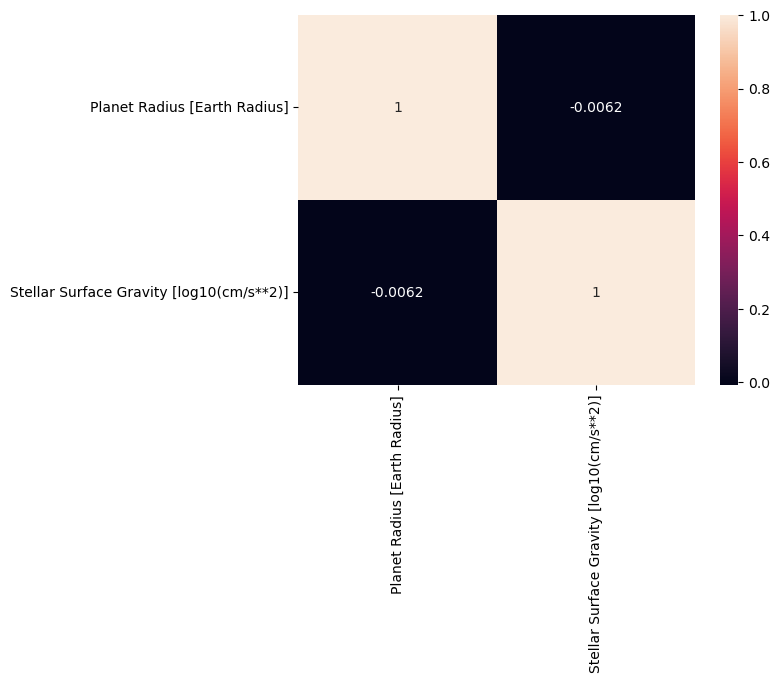

In [7]:
gravity_size = exoplanets[['Planet Name','Planet Radius [Earth Radius]', 'Stellar Surface Gravity [log10(cm/s**2)]']]
gravity_size = gravity_size.dropna()
sns.heatmap(gravity_size.corr(method='pearson', numeric_only=True),annot=True)

### From a quick glance, there is very little correlation between the planet size and stellar gravity, so let's have a look at planet size and its orbital period. 

<Axes: >

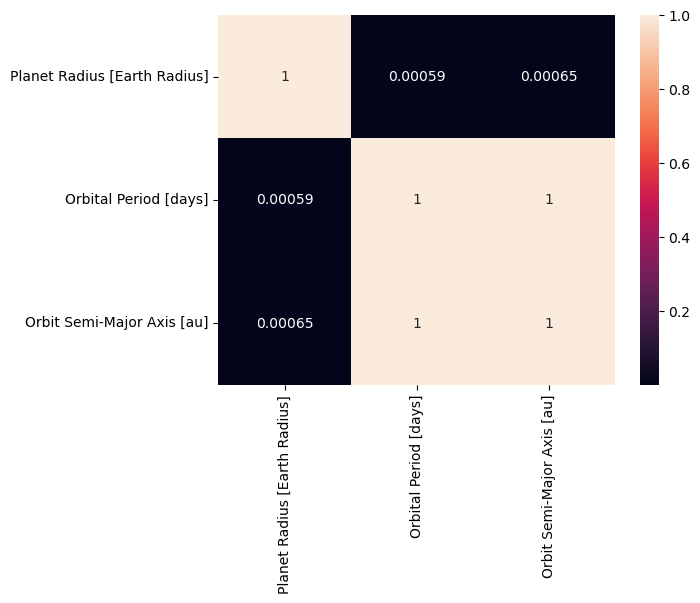

In [9]:
orbital_size = exoplanets[['Planet Name','Planet Radius [Earth Radius]', 'Orbital Period [days]', 'Orbit Semi-Major Axis [au]']]
orbital_size = orbital_size.dropna()
sns.heatmap(orbital_size.corr(method='pearson', numeric_only=True),annot=True)

In [10]:
discovery = exoplanets[['Planet Name', 'Host Name', 'Discovery Method', 'Discovery Year',
       'Discovery Facility', 'Solution Type']]
discovery.describe

<bound method NDFrame.describe of                 Planet Name           Host Name Discovery Method  \
0      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
1      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
2      11 Comae Berenices b  11 Comae Berenices  Radial Velocity   
3        11 Ursae Minoris b    11 Ursae Minoris  Radial Velocity   
4        11 Ursae Minoris b    11 Ursae Minoris  Radial Velocity   
...                     ...                 ...              ...   
38085      ups Andromedae d      ups Andromedae  Radial Velocity   
38086          ups Leonis b          ups Leonis  Radial Velocity   
38087          xi Aquilae b          xi Aquilae  Radial Velocity   
38088          xi Aquilae b          xi Aquilae  Radial Velocity   
38089          xi Aquilae b          xi Aquilae  Radial Velocity   

       Discovery Year                      Discovery Facility  \
0                2007                        Xinglong Station   
1                20

In [11]:
count = discovery.groupby('Discovery Year').size()

In [12]:
discovery['Discovery Method'].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Transit Timing Variations', 'Astrometry',
       'Microlensing', 'Disk Kinematics', 'Orbital Brightness Modulation',
       'Pulsation Timing Variations', 'Pulsar Timing'], dtype=object)

In [13]:
exoplanets.groupby('Discovery Method').size().sort_values(ascending=False)

Discovery Method
Transit                          34445
Radial Velocity                   2584
Microlensing                       697
Transit Timing Variations          152
Imaging                            148
Eclipse Timing Variations           24
Orbital Brightness Modulation       21
Pulsar Timing                       13
Astrometry                           3
Pulsation Timing Variations          2
Disk Kinematics                      1
dtype: int64

<Axes: >

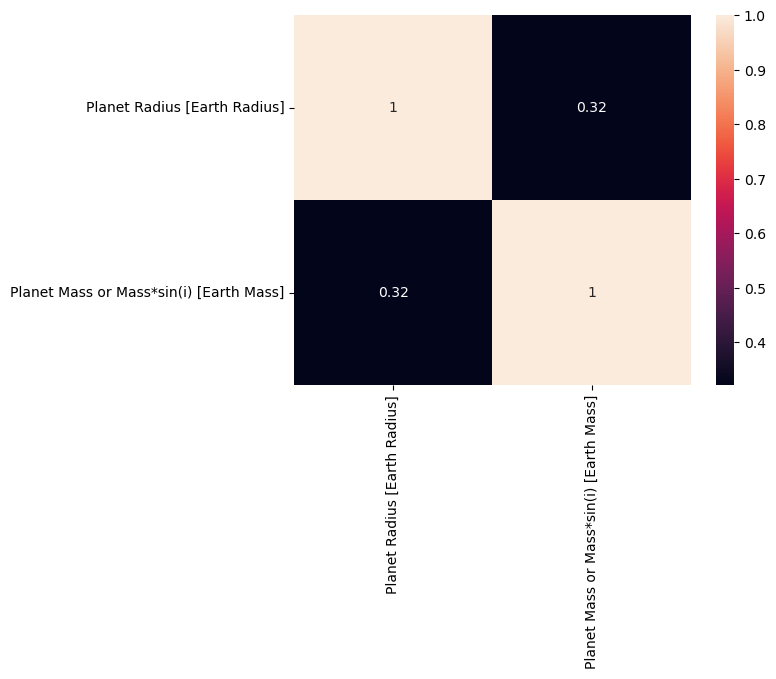

In [14]:
exoplanet_gravity = exoplanets[['Planet Name', 'Host Name','Planet Radius [Earth Radius]','Planet Mass or Mass*sin(i) [Earth Mass]']]

sns.heatmap(exoplanet_gravity.corr(method='pearson', numeric_only=True),annot=True)

In [15]:
exoplanet_sizes = exoplanets[['Planet Name', 'Host Name', 'Orbital Period [days]', 'Planet Radius [Earth Radius]',
                              'Orbit Semi-Major Axis [au]','Planet Radius [Jupiter Radius]','Planet Mass or Mass*sin(i) [Earth Mass]']]

exoplanet_sizes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38090 entries, 0 to 38089
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Planet Name                              38090 non-null  object 
 1   Host Name                                38090 non-null  object 
 2   Orbital Period [days]                    34904 non-null  float64
 3   Planet Radius [Earth Radius]             26414 non-null  float64
 4   Orbit Semi-Major Axis [au]               21538 non-null  float64
 5   Planet Radius [Jupiter Radius]           26414 non-null  float64
 6   Planet Mass or Mass*sin(i) [Earth Mass]  6331 non-null   float64
dtypes: float64(5), object(2)
memory usage: 2.0+ MB


<Axes: >

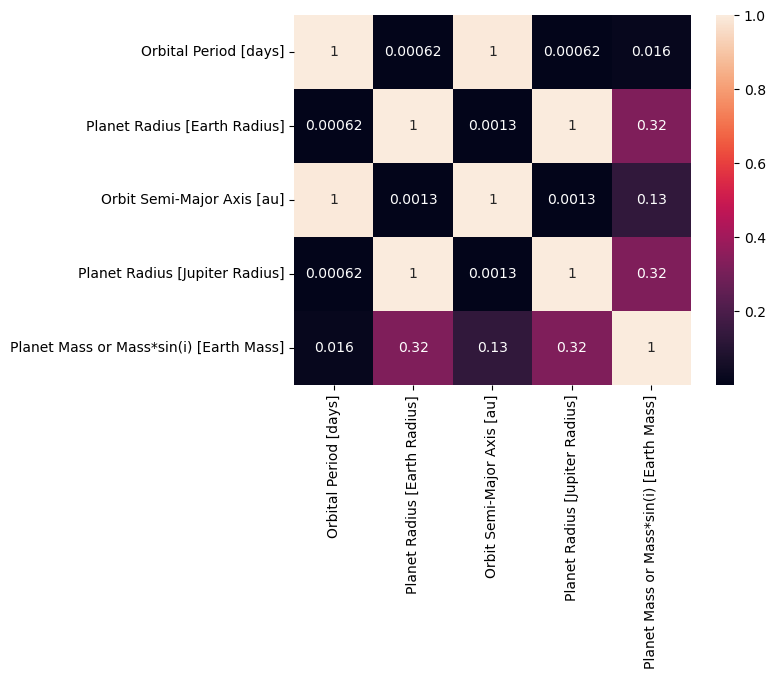

In [16]:
sns.heatmap(exoplanet_sizes.corr(method='pearson', numeric_only=True),annot=True)

# Let's instead take a look at the Discovery Facilities themselves.  

In [18]:
exoplanets['Discovery Facility'].unique()

array(['Xinglong Station', 'Thueringer Landessternwarte Tautenburg',
       'Okayama Astrophysical Observatory', 'W. M. Keck Observatory',
       'Multiple Observatories', 'Lick Observatory', 'Gemini Observatory',
       'Subaru Telescope', 'Paranal Observatory',
       'Cerro Tololo Inter-American Observatory', 'Mauna Kea Observatory',
       'European Space Agency (ESA) Gaia Satellite',
       'Hubble Space Telescope', 'Kepler', 'Haute-Provence Observatory',
       'McDonald Observatory', 'Anglo-Australian Telescope',
       'Bohyunsan Optical Astronomical Observatory',
       'Transiting Exoplanet Survey Satellite (TESS)',
       'Roque de los Muchachos Observatory', 'K2',
       'Wide-field Infrared Survey Explorer (WISE) Sat',
       'La Silla Observatory', 'Calar Alto Observatory',
       'NASA Infrared Telescope Facility (IRTF)', 'CoRoT',
       'Multiple Facilities', 'Yunnan Astronomical Observatory',
       'Spitzer Space Telescope', 'MEarth Project',
       'Very Long Baselin

In [19]:
count = exoplanets.groupby('Discovery Facility').size()
count = count.sort_values(ascending=False)

print(count)

Discovery Facility
Kepler                                            28217
K2                                                 2017
Transiting Exoplanet Survey Satellite (TESS)       1581
SuperWASP                                           964
W. M. Keck Observatory                              648
                                                  ...  
Wide-field Infrared Survey Explorer (WISE) Sat        1
Winer Observatory                                     1
Apache Point Observatory                              1
Leoncito Astronomical Complex                         1
Teide Observatory                                     1
Length: 71, dtype: int64


In [20]:
count = exoplanets.groupby('Discovery Method').size()
count = count.sort_values(ascending=False)

print(count)

Discovery Method
Transit                          34445
Radial Velocity                   2584
Microlensing                       697
Transit Timing Variations          152
Imaging                            148
Eclipse Timing Variations           24
Orbital Brightness Modulation       21
Pulsar Timing                       13
Astrometry                           3
Pulsation Timing Variations          2
Disk Kinematics                      1
dtype: int64


In [21]:
count = exoplanets.groupby('Discovery Year').size()
#count = count.sort_values(ascending=False)

print(count)

Discovery Year
1992        6
1994        2
1995        5
1996       41
1997        4
1998       39
1999       80
2000       78
2001       58
2002      144
2003       87
2004      173
2005      161
2006      149
2007      323
2008      332
2009      427
2010      615
2011     1072
2012     1150
2013     1074
2014     9644
2015      935
2016    13295
2017      579
2018      963
2019      545
2020      918
2021     2859
2022      776
2023     1031
2024      511
2025       14
dtype: int64


In [22]:
orbital_size.describe()

,Planet Radius [Earth Radius],Orbital Period [days],Orbit Semi-Major Axis [au]
count,18383.000000,1.838300e+04,18383.000000
mean,5.998098,2.297949e+04,0.600061
std,87.087893,2.966155e+06,55.502574
min,0.270000,1.797150e-01,0.005800
25%,1.510000,4.417694e+00,0.051400
50%,2.220000,1.000653e+01,0.087800
75%,3.120000,2.309266e+01,0.156175
max,4282.980000,4.020000e+08,7506.000000


In [23]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
# Let's add an encoding to the discovery facility so it can be used as a metric
exoplanets['Discovery Facility Encoded'] = encoder.fit_transform(exoplanets['Discovery Facility'])
exoplanets['Discovery Method Encoded'] = encoder.fit_transform(exoplanets['Discovery Method'])

print(exoplanets['Discovery Method'].unique(), '\n', exoplanets['Discovery Method Encoded'].unique())



['Radial Velocity' 'Imaging' 'Eclipse Timing Variations' 'Transit'
 'Transit Timing Variations' 'Astrometry' 'Microlensing' 'Disk Kinematics'
 'Orbital Brightness Modulation' 'Pulsation Timing Variations'
 'Pulsar Timing'] 
 [ 8  3  2  9 10  0  4  1  5  7  6]


### Let's now consider the different factors of discoveries over time with respect to different facilities and see what we are able to find.

<Axes: >

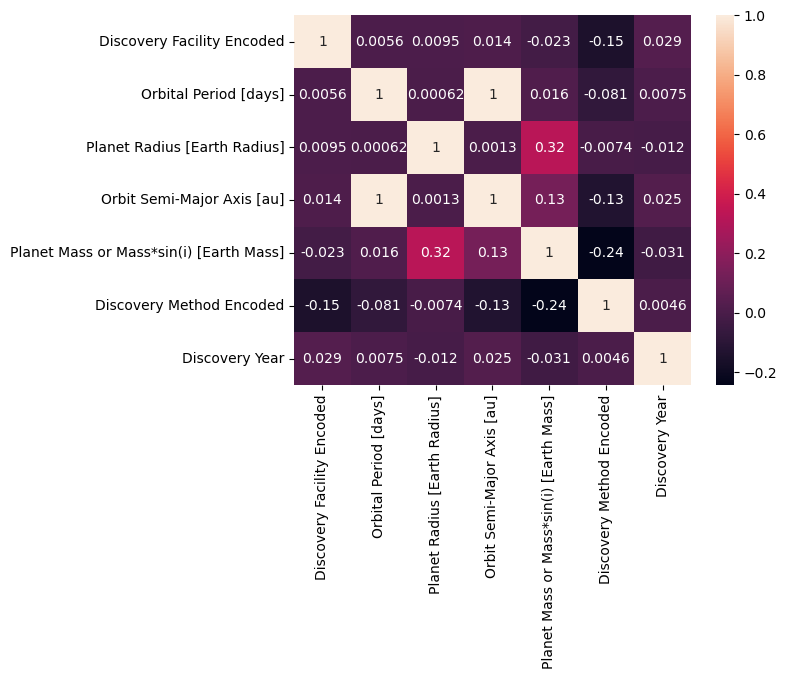

In [25]:
facility_finds = exoplanets[['Discovery Facility','Discovery Facility Encoded', 'Orbital Period [days]', 'Planet Radius [Earth Radius]',
                              'Orbit Semi-Major Axis [au]', 'Planet Mass or Mass*sin(i) [Earth Mass]', 
                             'Discovery Method', 'Discovery Method Encoded', 'Discovery Year']]

sns.heatmap(facility_finds.corr(method='pearson', numeric_only=True),annot=True)

# There does not appear to be a means of a binary solution to this data, so let's instead investigate k-means clustering and see what clusters it generates.

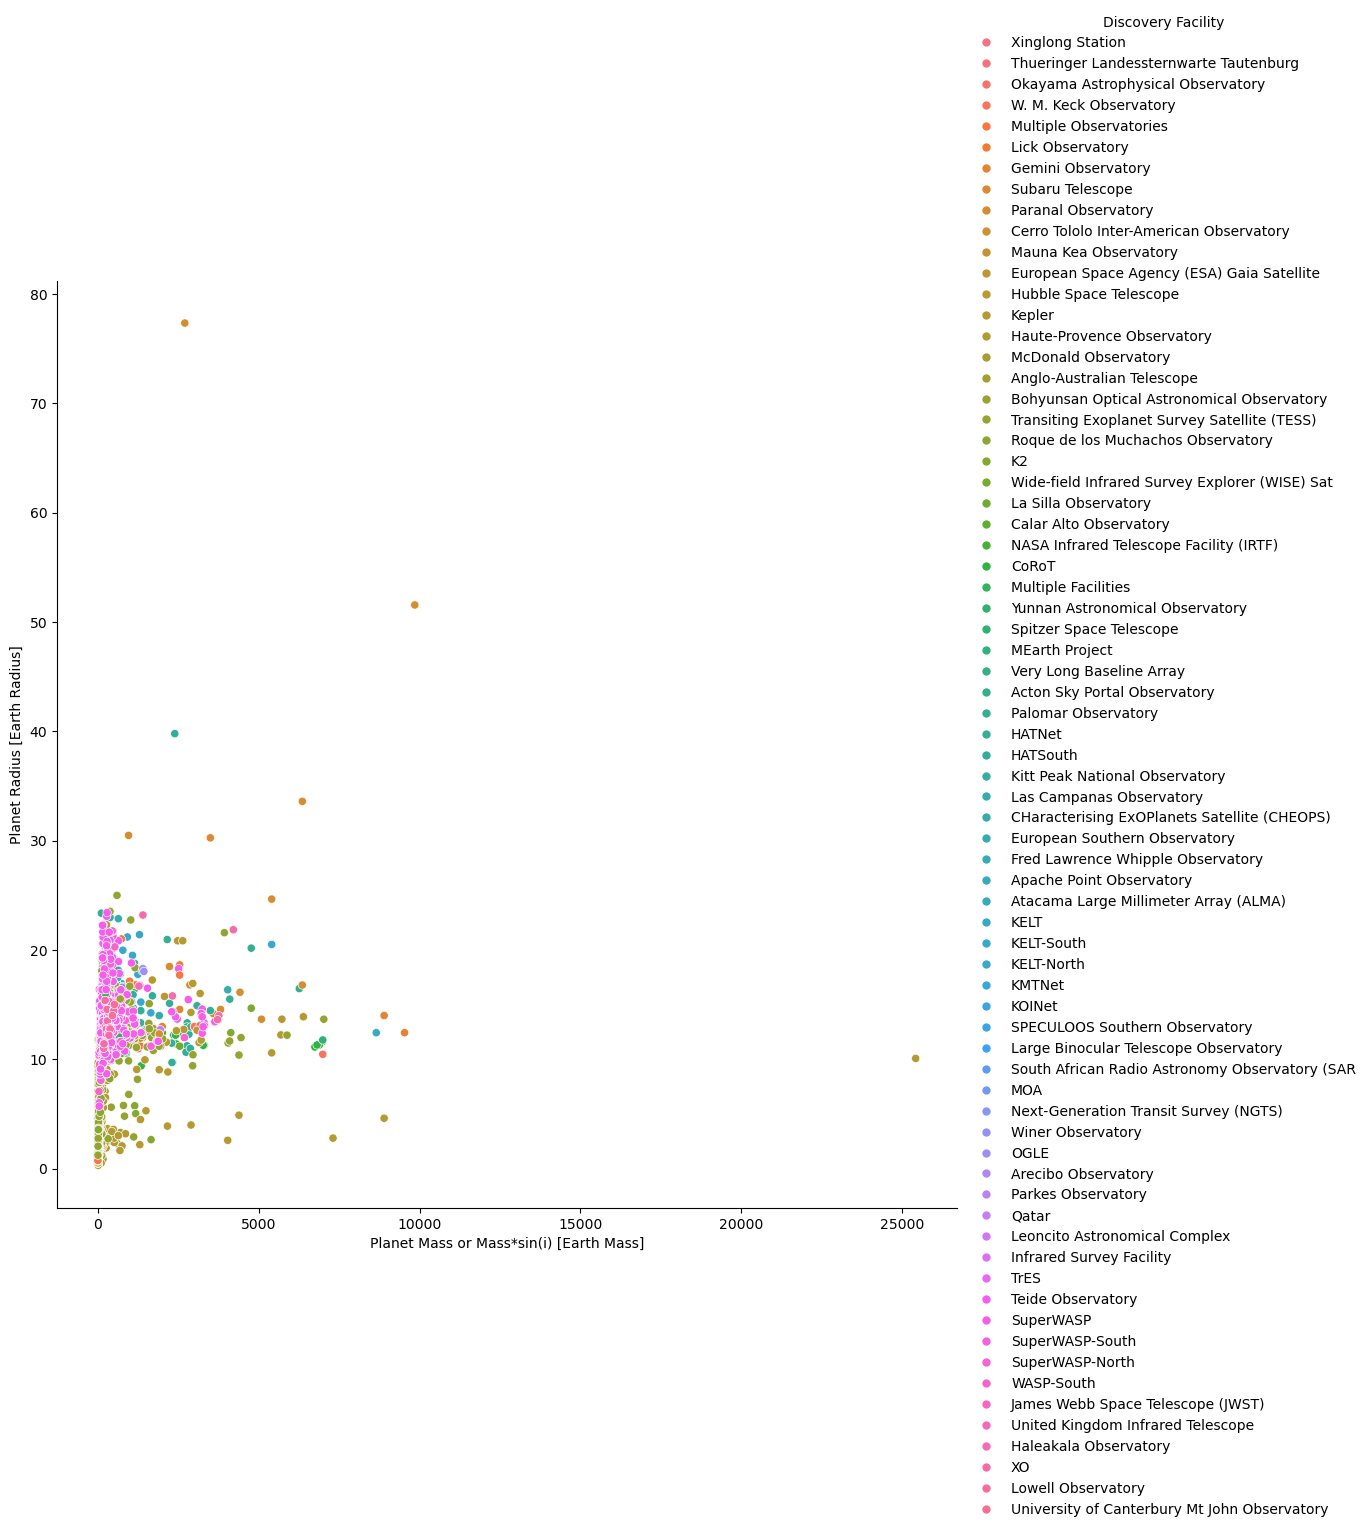

In [27]:
X = facility_finds
sns.relplot(x='Planet Mass or Mass*sin(i) [Earth Mass]', y='Planet Radius [Earth Radius]', data=X, height=10, hue='Discovery Facility');

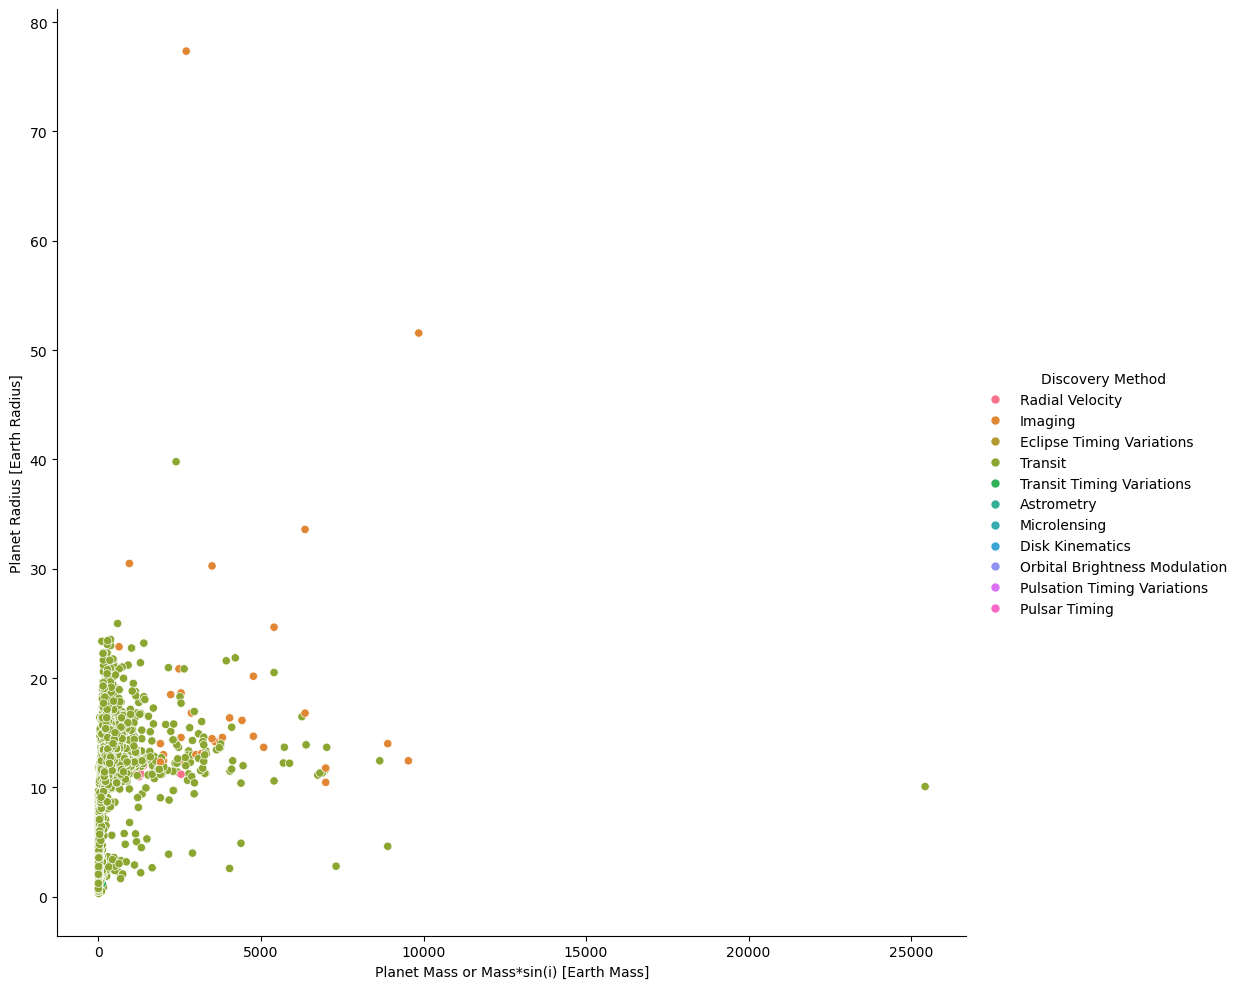

In [28]:
sns.relplot(x='Planet Mass or Mass*sin(i) [Earth Mass]', y='Planet Radius [Earth Radius]', data=X, height=10, hue='Discovery Method');

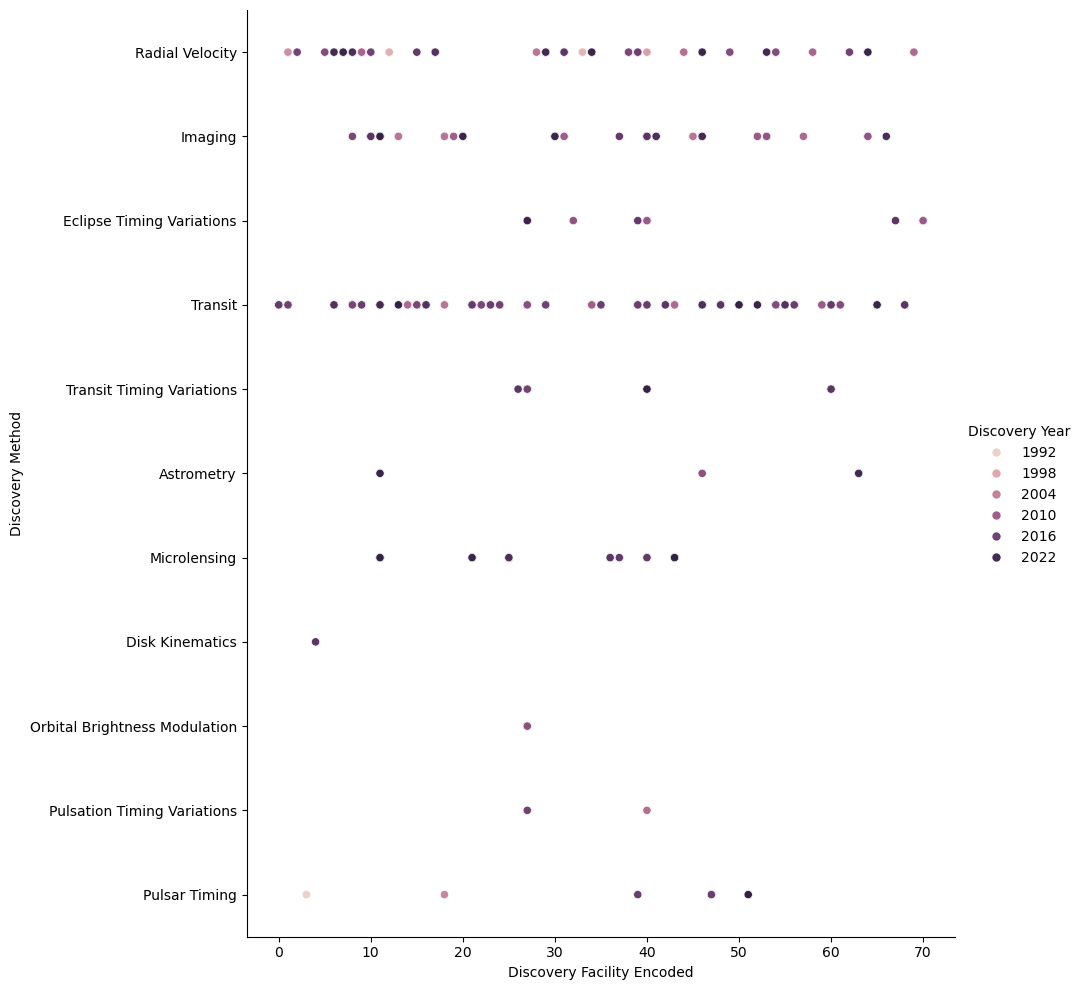

In [29]:
sns.relplot(x='Discovery Facility Encoded', y='Discovery Method', data=X, height=10, hue='Discovery Year');

In [30]:
Xarray = exoplanets[['Discovery Facility Encoded', 'Orbital Period [days]', 'Planet Radius [Earth Radius]',
                               'Discovery Method Encoded', 'Discovery Year']]
Xarray = Xarray.dropna()
vals = Xarray.values
print(vals)

[[3.800000e+01 7.370000e-01 1.897000e+00 8.000000e+00 2.004000e+03]
 [3.800000e+01 7.365474e-01 1.875000e+00 8.000000e+00 2.004000e+03]
 [3.800000e+01 7.365390e-01 1.910000e+00 8.000000e+00 2.004000e+03]
 ...
 [6.000000e+01 6.267900e+00 2.042000e+00 9.000000e+00 2.018000e+03]
 [6.000000e+01 6.268340e+00 2.060000e+00 9.000000e+00 2.018000e+03]
 [6.000000e+01 6.267832e+00 1.998000e+00 9.000000e+00 2.018000e+03]]


In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

kmodel = KMeans(n_clusters=8, random_state=42)

kmodel = kmodel.fit(scale(Xarray))

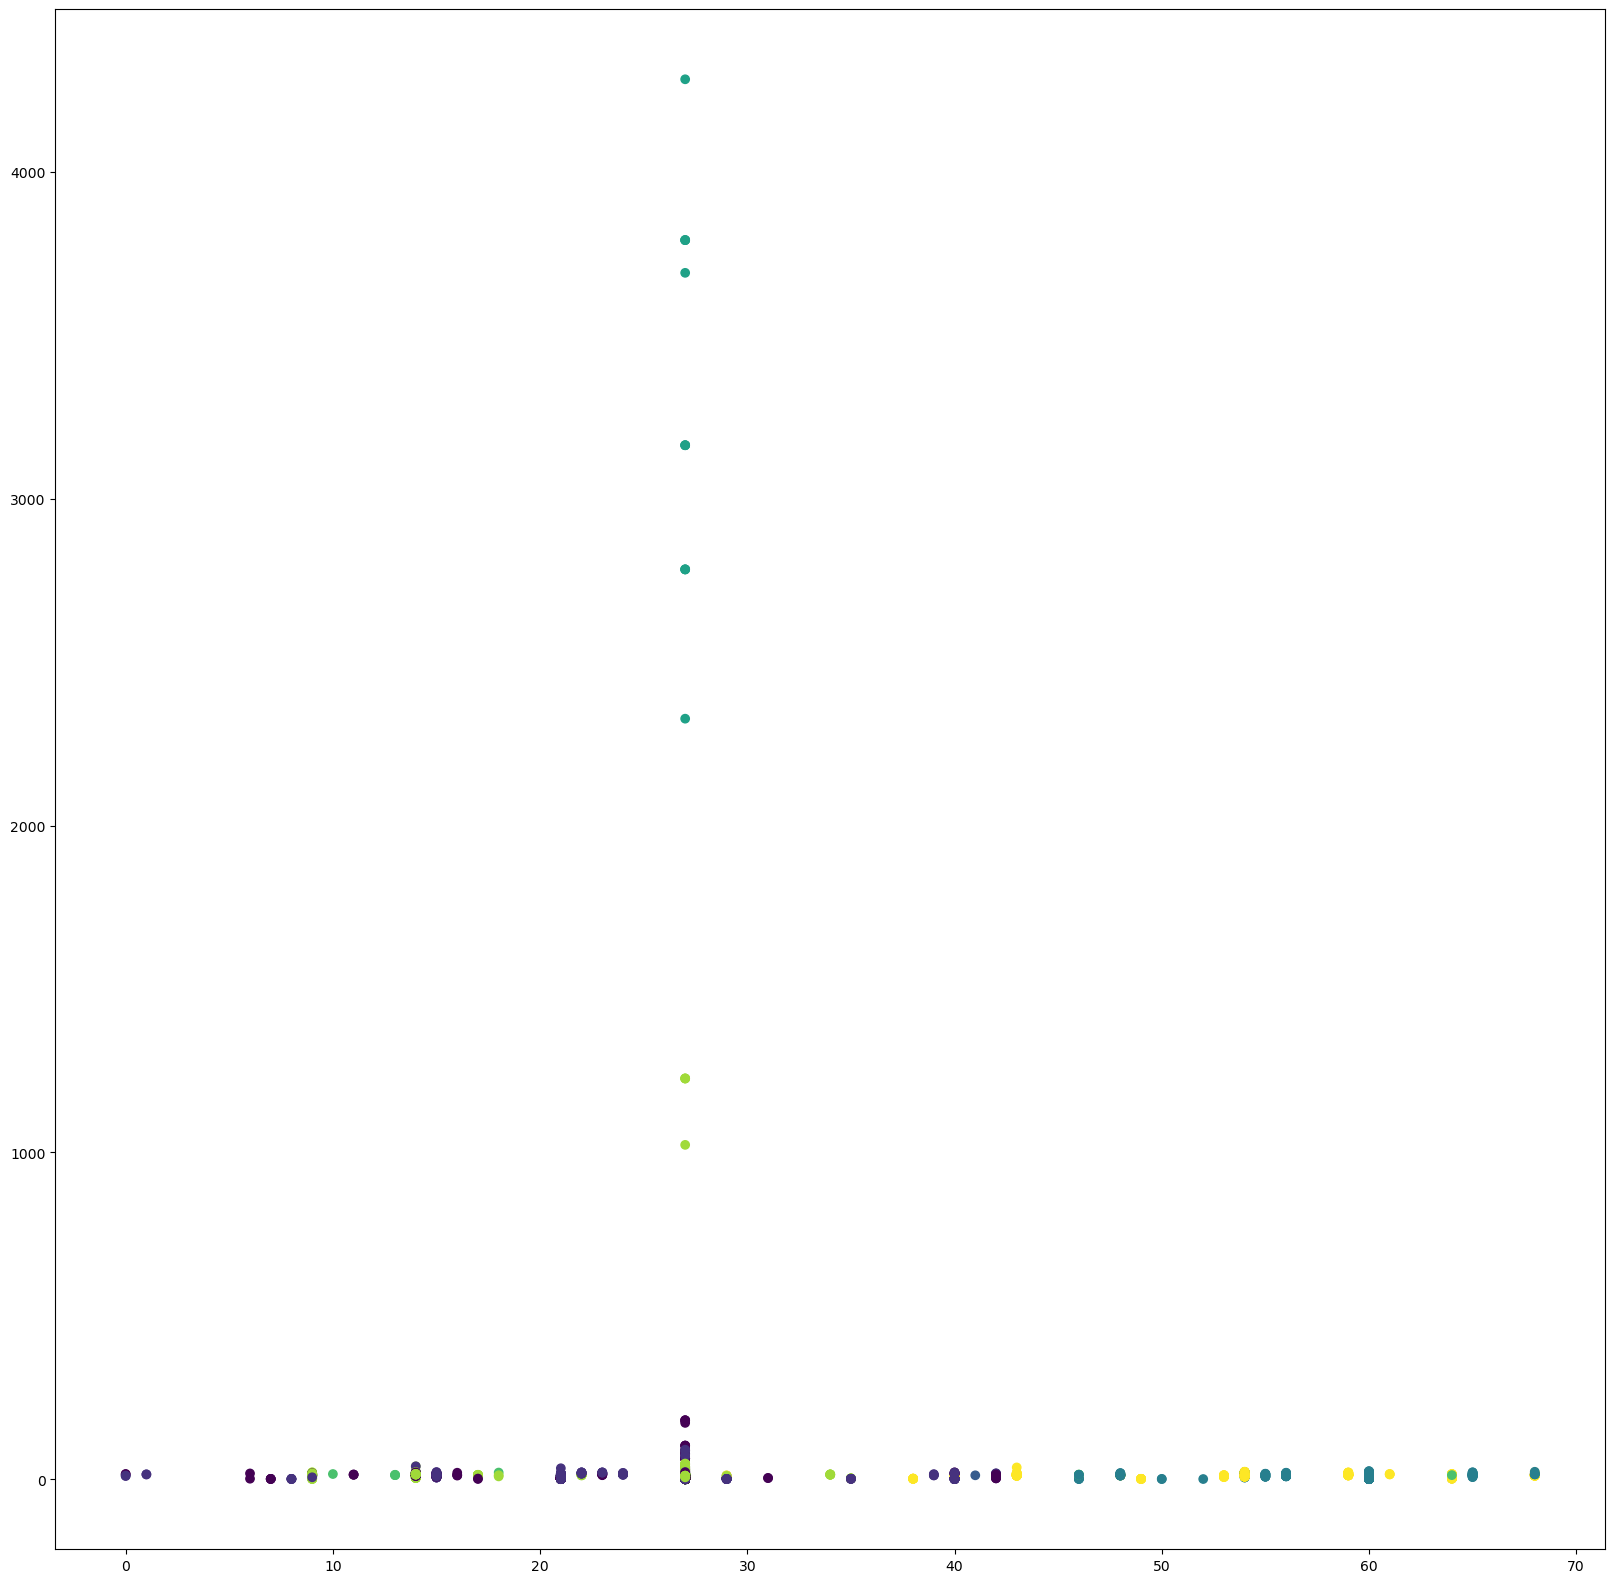

In [32]:
plt.figure(figsize=(20, 20))
plt.scatter(Xarray['Discovery Facility Encoded'], Xarray['Planet Radius [Earth Radius]'], c=kmodel.labels_.astype(float))
plt.show()


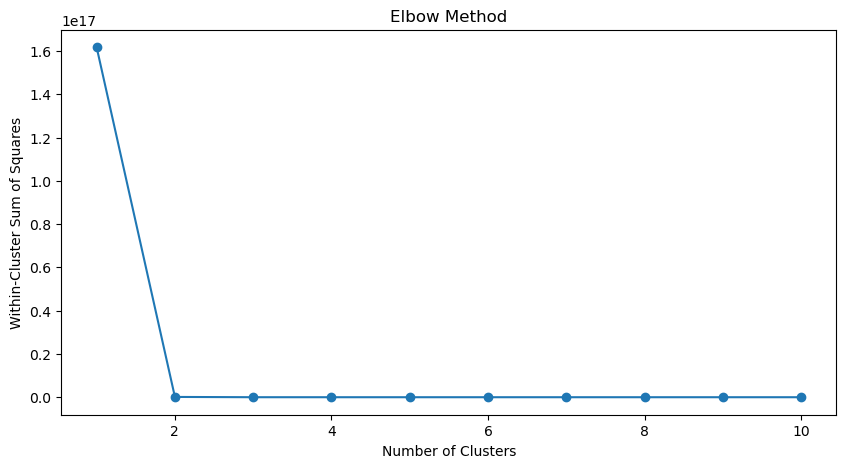

In [33]:
wss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Xarray)
    wss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.show()

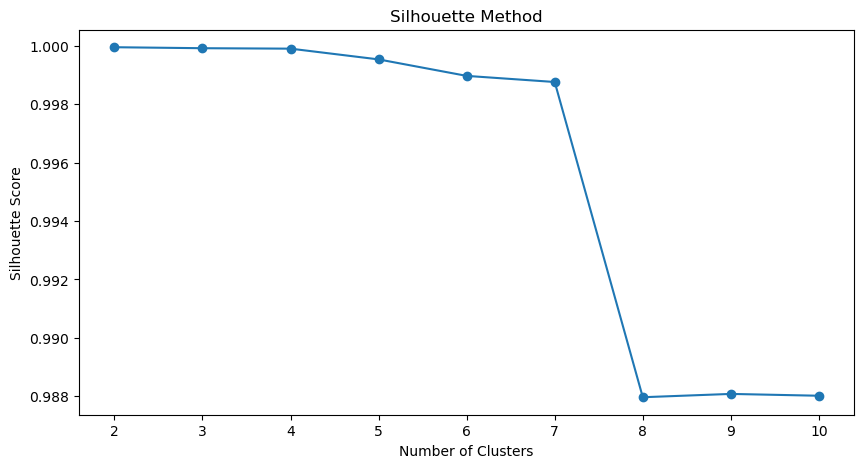

In [34]:
from sklearn.metrics import silhouette_score

silhouette = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(Xarray)
    silhouette_avg = silhouette_score(Xarray, cluster_labels)
    silhouette.append(silhouette_avg)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

###  So, there are difficulties in finding patterns looking at the broad spectrum, so let's try looking at specific Discovery Facilities

In [64]:
kepler = exoplanets.loc[exoplanets['Discovery Facility'] == 'Kepler']

In [66]:
kepler.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28217 entries, 47 to 35075
Data columns (total 94 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Planet Name                                           28217 non-null  object 
 1   Host Name                                             28217 non-null  object 
 2   Default Parameter Set                                 28217 non-null  int64  
 3   Number of Stars                                       28217 non-null  int64  
 4   Number of Planets                                     28217 non-null  int64  
 5   Discovery Method                                      28217 non-null  object 
 6   Discovery Year                                        28217 non-null  int64  
 7   Discovery Facility                                    28217 non-null  object 
 8   Solution Type                                         28217 

In [69]:
k_two = exoplanets.loc[exoplanets['Discovery Facility'] == 'K2']

In [71]:
k_two.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017 entries, 191 to 37873
Data columns (total 94 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Planet Name                                           2017 non-null   object 
 1   Host Name                                             2017 non-null   object 
 2   Default Parameter Set                                 2017 non-null   int64  
 3   Number of Stars                                       2017 non-null   int64  
 4   Number of Planets                                     2017 non-null   int64  
 5   Discovery Method                                      2017 non-null   object 
 6   Discovery Year                                        2017 non-null   int64  
 7   Discovery Facility                                    2017 non-null   object 
 8   Solution Type                                         2017 n

In [121]:
columns_to_keep = [col for col in kepler.columns if 'unc' not in col.lower()]
columns_to_keep = [col for col in columns_to_keep if 'flag' not in col.lower()]
columns_to_keep = [col for col in columns_to_keep if 'reference' not in col.lower()]
columns_to_keep = [col for col in columns_to_keep if 'lower' not in col.lower()]
kepler_filtered = kepler[columns_to_keep]
k_two_filtered = k_two[columns_to_keep]

In [123]:
kepler_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28217 entries, 47 to 35075
Data columns (total 39 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Planet Name                                28217 non-null  object 
 1   Host Name                                  28217 non-null  object 
 2   Default Parameter Set                      28217 non-null  int64  
 3   Number of Stars                            28217 non-null  int64  
 4   Number of Planets                          28217 non-null  int64  
 5   Discovery Method                           28217 non-null  object 
 6   Discovery Year                             28217 non-null  int64  
 7   Discovery Facility                         28217 non-null  object 
 8   Solution Type                              28217 non-null  object 
 9   Orbital Period [days]                      26003 non-null  float64
 10  Orbit Semi-Major Axis [au]

In [125]:
k_two_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017 entries, 191 to 37873
Data columns (total 39 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Planet Name                                2017 non-null   object 
 1   Host Name                                  2017 non-null   object 
 2   Default Parameter Set                      2017 non-null   int64  
 3   Number of Stars                            2017 non-null   int64  
 4   Number of Planets                          2017 non-null   int64  
 5   Discovery Method                           2017 non-null   object 
 6   Discovery Year                             2017 non-null   int64  
 7   Discovery Facility                         2017 non-null   object 
 8   Solution Type                              2017 non-null   object 
 9   Orbital Period [days]                      2009 non-null   float64
 10  Orbit Semi-Major Axis [au]

In [ ]:
kepler_filtered[Data show Transit Timing Variations'] 